# Contrastive Learning - Lab Rotation project

### Andreea-Maria Gui, BCCN
##### July, 2022

#### 1. Technical preparation

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
# standard python packages
import os, sys
from glob import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import h5py

# pytorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader

# sklearn functions
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc

/home/andreea-maria/miniconda3/envs/debugger_env/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# load functions from nitorch
sys.path.insert(1, "../nitorch")
from nitorch.transforms import  *
from nitorch.callbacks import EarlyStopping, ModelCheckpoint, Callback
from nitorch.trainer import Trainer
from nitorch.metrics import binary_balanced_accuracy, sensitivity, specificity
from nitorch.utils import count_parameters
from nitorch.initialization import weights_init
from nitorch.data import show_brain

In [4]:
torch.__version__

'1.11.0'

In [5]:
! gpustat

cuda01                         Thu Aug  4 12:26:48 2022  470.129.06
[0] NVIDIA GeForce GTX 1080 Ti | 27'C,   0 % |     8 / 11178 MB | gdm(4M)
[1] NVIDIA GeForce GTX 1080 Ti | 29'C,   0 % |     8 / 11178 MB | gdm(4M)
[2] NVIDIA GeForce GTX 1080 Ti | 28'C,   0 % |     8 / 11178 MB | gdm(4M)
[3] NVIDIA GeForce GTX 1080 Ti | 29'C,   0 % |     8 / 11178 MB | gdm(4M)
[4] NVIDIA GeForce GTX 1080 Ti | 27'C,   0 % |     8 / 11178 MB | gdm(4M)
[5] NVIDIA GeForce GTX 1080 Ti | 27'C,   0 % |     8 / 11178 MB | gdm(4M)
[6] NVIDIA GeForce GTX 1080 Ti | 29'C,   0 % |   975 / 11178 MB | andreea-maria(967M) gdm(4M)
[7] NVIDIA GeForce GTX 1080 Ti | 28'C,   0 % |   655 / 11178 MB | andreea-maria(647M) gdm(4M)


In [6]:
# Select a GPU to use
GPU = 7
# set random seeds for replicable runs
RANDOM_STATE=None #initially 45

# the output folder to store trained models and results
output_dir='tut_outputs'
os.makedirs(output_dir, exist_ok=True)

In [7]:
if RANDOM_STATE:
    torch.manual_seed(RANDOM_STATE)
    np.random.seed(RANDOM_STATE)
    import random
    random.seed(RANDOM_STATE)

#### 2. Data preparation and check

In [8]:
N = 640 # total data samples to use

data_ukbb = h5py.File("/ritter/share/data/tutorial_h5files/ukbb-z2-sex-age-alc-n14617.h5", 'r')
# set the label y as 'sex' and use only 1000 subjects
X, y = data_ukbb['X'][:N], data_ukbb['age'][:N] #change to age, not sex

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=N//10, random_state=RANDOM_STATE, shuffle=True)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=N//10, random_state=RANDOM_STATE, shuffle=True)

In [10]:
y_val_map = {0.0:'Male', 1.0:'Female'}
print(f'Training data  :   n={len(y_train)} \t\
y distribution= {dict(pd.Series(y_train).map(y_val_map).value_counts())}')
print(f'Validation data:   n={len(y_val)} \t\
y distribution= {dict(pd.Series(y_val).map(y_val_map).value_counts())}')
print(f'Test data      :   n={len(y_test)} \t\
y distribution= {dict(pd.Series(y_test).map(y_val_map).value_counts())}')

Training data  :   n=512 	y distribution= {}
Validation data:   n=64 	y distribution= {}
Test data      :   n=64 	y distribution= {}


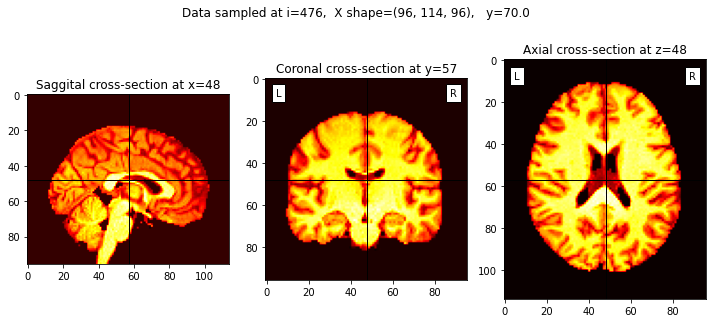

In [11]:
rand_idx = np.random.randint(0, len(y_train))
X_i, y_i = X_train[rand_idx], y_train[rand_idx]
show_brain(X_i, cmap='hot') 
plt.suptitle(f"Data sampled at i={rand_idx},  X shape={X_i.shape},   y={y_i}")
plt.show()

Voxel value at [1,1,1] = 0.0 (expected val around the brain is 0)


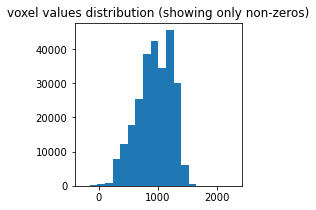

In [12]:
print(f"Voxel value at [1,1,1] = {X_i[1,1,1]} (expected val around the brain is 0)")
# show voxel values distribution
vals = X_i.ravel()
vals = vals[vals != 0]
plt.figure(figsize=(3,3))
plt.hist(vals, bins=20)
plt.title("voxel values distribution (showing only non-zeros)")
plt.show()

#### 3. Dataset - for 3D data and CL

In [13]:
from collections import namedtuple

class Transformer(object):
    """ Class that can be used to register a sequence of transformations.
    """
    Transform = namedtuple("Transform", ["transform", "probability"])

    def __init__(self):
        """ Initialize the class.
        """
        self.transforms = []

    def register(self, transform, probability=1):
        """ Register a new transformation.
        Parameters
        ----------
        transform: callable
            the transformation object.
        probability: float, default 1
            the transform is applied with the specified probability.
        """
        trf = self.Transform(transform=transform, probability=probability, )
        self.transforms.append(trf)

    def __call__(self, arr):
        """ Apply the registered transformations.
        """
        transformed = arr.copy()
        for trf in self.transforms:
            if np.random.rand() < trf.probability:
                transformed = trf.transform(transformed)
        return transformed

    def __str__(self):
        if len(self.transforms) == 0:
            return '(Empty Transformer)'
        s = 'Composition of:'
        for trf in self.transforms:
            s += '\n\t- '+trf.__str__()
        return s

In [14]:
# from augmentations import Transformer, Cutout, Noise, Normalize, Blur, Flip

class MRIDataset(Dataset):

    def __init__(self, X, y, tf='mri_tf', input_size=(96, 114, 96), training=True, validation=False, *args, **kwargs):
        super().__init__(*args, **kwargs)
        assert training != validation

        self.transforms = Transformer()
        self.transforms.register(Normalize(), probability=1.0)
        self.data = X
        self.labels = y
        
        self.transforms_2 = Transformer()
        self.transforms_2.register(Normalize(), probability=1.0)
        
        self.base_transforms = Transformer()
        self.base_transforms.register(Normalize(), probability=1.0)
        self.base_transforms.register(IntensityRescale(masked=True), probability=1.0)
        self.base_transforms.register(ToTensor(), probability=1.0)

        if tf == 'test':
            self.transforms.register(IntensityRescale(masked=True))
            self.transforms.register(ToTensor())
        elif tf == 'mri_tf':
            self.transforms.register(SagittalFlip(prob=0.5), probability=1) #probability 0.5 before
            self.transforms.register(SagittalTranslate(dist=(-5, 5)), probability=0.5) 
            # add more: other flips, other trnslations
            self.transforms.register(CoronalFlip(prob=0.5), probability=1)
            self.transforms.register(AxialFlip(prob=0.5), probability=1)
            self.transforms.register(CoronalTranslate(dist=(-5, 5)), probability=0.5) 
            self.transforms.register(AxialTranslate(dist=(-5, 5)), probability=0.5) 
            
            self.transforms.register(IntensityRescale(masked=True))
            self.transforms.register(ToTensor())
            
            # self.transforms_2.register(SagittalFlip(prob=0.5), probability=1) #probability 0.5 before
            # self.transforms_2.register(SagittalTranslate(dist=(-5, 5)), probability=0.5) 
            # self.transforms_2.register(IntensityRescale(masked=True))
            # self.transforms_2.register(ToTensor())
            
        # print(self.data.shape[1:])
        assert self.data.shape[1:] == tuple(input_size), "3D images must have shape {}".\
            format(input_size)
    
    def __getitem__(self, idx):
        
        # 2 options 1) each image is trasnformed 2) only one image is transformed
        # For a single input x, samples (t, t') ~ T to generate (t(x), t'(x))
        np.random.seed()
        # x1 = self.transforms_2(self.data[idx]) # option 1) is used here
        x1 = self.base_transforms(self.data[idx]) # option 2) is used here
        x2 = self.transforms(self.data[idx])
        
        # labels = self.labels[self.config.label_name].values[idx]
        labels = self.labels[idx]
        x = np.stack((x1, x2), axis=0)

        return (x, labels)

    def __len__(self):
        return len(self.data)

In [15]:
dataset_train_cl = MRIDataset(X_train, y_train, tf='mri_tf')
dataset_val_cl = MRIDataset(X_val, y_val, tf='mri_tf')
dataset_test_cl = MRIDataset(X_test, y_test, tf='test')
# print(len(dataset_train_cl))
# print(len(dataset_val_cl))

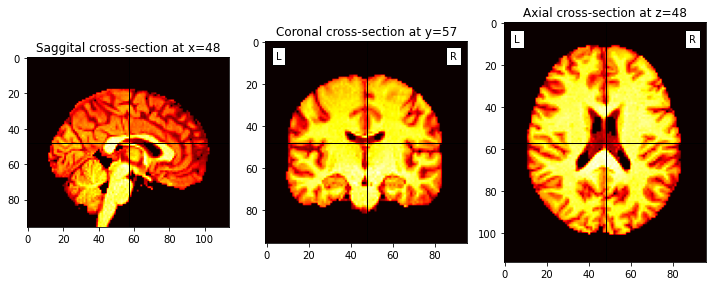

observe also that the image has moved to left. This means that a SaggitalTranslate augmentation was applied randomly on this subject
Voxel value at [1,1,1] = 0.0 (expected val around the brain is 0)


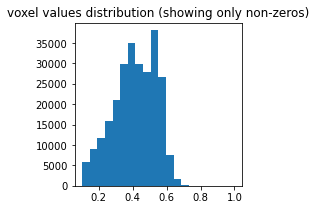

In [16]:
data = dataset_train_cl[rand_idx] #dataset_train
#remove the extra batch dimension and convert the 'tensors' to numpy again
# print(len(data[0]))
X_i, y_i = data[0][0][0], data[0][1]
show_brain(X_i, cmap='hot')
# plt.suptitle(f"Data sampled at i={rand_idx},  X shape={X_i.shape},   y={y_i}")
plt.show()

print("observe also that the image has moved to left. This means that a SaggitalTranslate augmentation was applied randomly on this subject")

print(f"Voxel value at [1,1,1] = {X_i[1,1,1]} (expected val around the brain is 0)")
# show voxel values distribution
vals = X_i.ravel()
vals = vals[vals != 0]
plt.figure(figsize=(3,3))
plt.hist(vals, bins=20)
plt.title("voxel values distribution (showing only non-zeros)")
plt.show()

#### 4. The CL specific methods (loss functions, training callback, metrics)

In [17]:
class NTXenLoss(nn.Module):
    """
    Normalized Temperature Cross-Entropy Loss for Constrastive Learning
    Refer for instance to:
    Ting Chen, Simon Kornblith, Mohammad Norouzi, Geoffrey Hinton
    A Simple Framework for Contrastive Learning of Visual Representations, arXiv 2020
    """

    def __init__(self, temperature=0.1, return_logits=False):
        super().__init__()
        self.temperature = temperature
        self.INF = 1e8
        self.return_logits = return_logits

    def forward(self, outputs, labels):
        
        z_i = outputs[0]
        z_j = outputs[1]
        N = len(z_i)
        z_i = F.normalize(z_i, p=2, dim=-1) # dim [N, D]
        z_j = F.normalize(z_j, p=2, dim=-1) # dim [N, D]
        sim_zii= (z_i @ z_i.T) / self.temperature # dim [N, N] => Upper triangle contains incorrect pairs
        sim_zjj = (z_j @ z_j.T) / self.temperature # dim [N, N] => Upper triangle contains incorrect pairs
        sim_zij = (z_i @ z_j.T) / self.temperature # dim [N, N] => the diag contains the correct pairs (i,j) (x transforms via T_i and T_j)
        # 'Remove' the diag terms by penalizing it (exp(-inf) = 0)
        sim_zii = sim_zii - self.INF * torch.eye(N, device=z_i.device)
        sim_zjj = sim_zjj - self.INF * torch.eye(N, device=z_i.device)
        correct_pairs = torch.arange(N, device=z_i.device).long()
        loss_i = F.cross_entropy(torch.cat([sim_zij, sim_zii], dim=1), correct_pairs)
        loss_j = F.cross_entropy(torch.cat([sim_zij.T, sim_zjj], dim=1), correct_pairs)
        
        # print(sim_zii.shape, sim_zii.min(), sim_zii.max())
        # print(sim_zjj.shape, sim_zjj.min(), sim_zjj.max())
        # print(sim_zij.shape, sim_zij.min(), sim_zij.max())
        # print(loss_i.item())
        # print(loss_j.item())
        # print(correct_pairs)

        if self.return_logits:
            return (loss_i + loss_j), sim_zij, correct_pairs

        return (loss_i + loss_j)

    def __str__(self):
        return "{}(temp={})".format(type(self).__name__, self.temperature)


In [18]:
import math
from sklearn.metrics.pairwise import rbf_kernel

class GeneralizedSupervisedNTXenLoss(nn.Module):
    """
    Class taken from: https://github.com/Duplums/yAwareContrastiveLearning
    Refer for instance to:
    Dufumier, B., Gori, P., Victor, J., Grigis, A., Wessa, M., Brambilla, P., ... 
    & Alzheimer’s Disease Neuroimaging Initiative. (2021, September). 
    Contrastive learning with continuous proxy meta-data for 3d mri classification. 
    In International Conference on Medical Image Computing and Computer-Assisted Intervention 
    (pp. 58-68). Springer, Cham.

    """
    def __init__(self, kernel='rbf', temperature=0.1, return_logits=False, sigma=1.0):
        """
        :param kernel: a callable function f: [K, *] x [K, *] -> [K, K]
                                              y1, y2          -> f(y1, y2)
                        where (*) is the dimension of the labels (yi)
        default: an rbf kernel parametrized by 'sigma' which corresponds to gamma=1/(2*sigma**2)

        :param temperature:
        :param return_logits:
        """

        # sigma = prior over the label's range
        super().__init__()
        self.kernel = kernel
        self.sigma = sigma
        if self.kernel == 'rbf':
            self.kernel = lambda y1, y2: rbf_kernel(y1, y2, gamma=1./(2*self.sigma**2))
        else:
            assert hasattr(self.kernel, '__call__'), 'kernel must be a callable'
        self.temperature = temperature
        self.return_logits = return_logits
        self.INF = 1e8

    def forward(self, outputs, labels):
        z_i = outputs[0]
        z_j = outputs[1]
        N = len(z_i)
        assert N == len(labels), "Unexpected labels length: %i"%len(labels)
        z_i = F.normalize(z_i, p=2, dim=-1) # dim [N, D]
        z_j = F.normalize(z_j, p=2, dim=-1) # dim [N, D]
        sim_zii= (z_i @ z_i.T) / self.temperature # dim [N, N] => Upper triangle contains incorrect pairs
        sim_zjj = (z_j @ z_j.T) / self.temperature # dim [N, N] => Upper triangle contains incorrect pairs
        sim_zij = (z_i @ z_j.T) / self.temperature # dim [N, N] => the diag contains the correct pairs (i,j) (x transforms via T_i and T_j)
        # 'Remove' the diag terms by penalizing it (exp(-inf) = 0)
        sim_zii = sim_zii - self.INF * torch.eye(N, device=z_i.device)
        sim_zjj = sim_zjj - self.INF * torch.eye(N, device=z_i.device)

        all_labels = labels.view(N, -1).repeat(2, 1).detach().cpu().numpy() # [2N, *]
        weights = self.kernel(all_labels, all_labels) # [2N, 2N]
        weights = weights * (1 - np.eye(2*N)) # puts 0 on the diagonal
        weights /= weights.sum(axis=1)
        # if 'rbf' kernel and sigma->0, we retrieve the classical NTXenLoss (without labels)
        sim_Z = torch.cat([torch.cat([sim_zii, sim_zij], dim=1), torch.cat([sim_zij.T, sim_zjj], dim=1)], dim=0) # [2N, 2N]
        log_sim_Z = F.log_softmax(sim_Z, dim=1)

        loss = -1./N * (torch.from_numpy(weights).to(z_i.device) * log_sim_Z).sum()

        correct_pairs = torch.arange(N, device=z_i.device).long()

        if self.return_logits:
            return loss, sim_zij, correct_pairs

        return loss

    def __str__(self):
        return "{}(temp={}, kernel={}, sigma={})".format(type(self).__name__, self.temperature,
                                                         self.kernel.__name__, self.sigma)


In [19]:
class CLCallback(Callback):
    ''' training_time_callback that computes the outputs of 2 batches to compute
    the CL losses
    '''
    def __init__(self, model):
        self.model = model

    def __call__(self, inputs, labels, train_iter, epoch):
        z_i = self.model.forward(inputs[:, 0, :])
        z_j = self.model.forward(inputs[:, 1, :])
        # z_i = model.encode(net, x=inputs[:, 0, :]).detach().cpu().numpy()
        # z_j = model.encode(net, inputs[:, 1, :]).detach().cpu().numpy()
        
        # print(euclidean_metric(z_i.detach().cpu().numpy(), z_j.detach().cpu().numpy()))
        return [z_i, z_j]

In [20]:
import scipy.spatial.distance as spdist

def euclidean_metric(z_i, z_j):
    assert len(z_i) == len(z_j)
    batch_size = len(z_i)
    distance = 0
    for i in range(batch_size):
        distance += spdist.pdist([z_i[i], z_j[i]], 'euclidean')
    return distance

def euclidean_metric_2(outputs, labels):
    print('[d]', outputs)
    out_copy = outputs.detach()
    print(out_copy.size())
    z_i = out_copy[0].cpu().numpy()
    print(z_i)
    # print('[d] z_i', z_i)
    z_j = out_copy[1].cpu().numpy()
    print(z_j)
    assert z_i.size == z_j.size
    print(z_i.size)
    # print(z_i.type)
    batch_size = z_i.size
    distance = 0
    for i in range(batch_size):
        distance += spdist.pdist([z_i[i], z_j[i]], 'euclidean')
    return distance

#### 5. The architecture

In [21]:
from CNNpipeline.models import FCN_3D, FCN_3D_hooked

In [22]:
# net = FCN_3D(convs   =  [16,   24,   32,   64,   96,   128,  100,   64], 
#                pools   =['max',False,'max',False,'max','max'         ],
#                kernels =[5,    5,    3,    3,    3,    3,  (3,4,3), 1],
#                dropout=   [0.2,  0.1                                   ],
#               in_shape=(96, 114, 96), debug_print=True,
#               out_classes=32)
net = FCN_3D(convs   =  [8,  16,   32,   64,   64,   96, 128,   128,  100,   64], 
               pools   =['', 'max','','max',   '','max',  '', '',         ],
               kernels =[3,   3,    3,    3,    3,    3,    3,    3,  (3,4,3), 1],
               dropout=   [0.1,  0.1                                   ],
              in_shape=(96, 114, 96), debug_print=True,
              out_classes=32)

print(f"Trainable model parameters: {count_parameters(net)}")
# print model architecture
net.apply(weights_init)
net = net.cuda(GPU)

output shape = [ 94 112  94] 	 after layer-0 conv (cout=8, kernel=3)
output shape = [ 92 110  92] 	 after layer-1 conv (cout=16, kernel=3)
output shape = [46 55 46] 	 layer-1 pool (max, kernel=2)
output shape = [44 53 44] 	 after layer-2 conv (cout=32, kernel=3)
output shape = [42 51 42] 	 after layer-3 conv (cout=64, kernel=3)
output shape = [21 25 21] 	 layer-3 pool (max, kernel=2)
output shape = [19 23 19] 	 after layer-4 conv (cout=64, kernel=3)
output shape = [17 21 17] 	 after layer-5 conv (cout=96, kernel=3)
output shape = [ 8 10  8] 	 layer-5 pool (max, kernel=2)
output shape = [6 8 6] 	 after layer-6 conv (cout=128, kernel=3)
output shape = [4 6 4] 	 after layer-7 conv (cout=128, kernel=3)
output shape = [2 3 2] 	 after layer-8 conv (cout=100, kernel=(3, 4, 3))
output shape = [2 3 2] 	 after layer-9 conv (cout=64, kernel=1)
Trainable model parameters: 1617324


#### 6. The trainer and training settings

Set the trainer parameters

In [23]:
#criterion
loss_type = 'yaware'
if loss_type == 'simclr':
    criterion = NTXenLoss()
else:
    criterion = GeneralizedSupervisedNTXenLoss(sigma=5.0)

# optimizer
optim_func = optim.Adam #try SGD for simclr loss as well
optim_params = {'lr': 0.001, 'weight_decay': 0.0001}
optimizer = optim_func(net.parameters(), **optim_params)

#scheduler
# learning rate scheduler to use and the l2 weight decay regularization to use
scheduler_func = optim.lr_scheduler.StepLR
scheduler_params = {'step_size': 10, 'gamma': 0.1}
scheduler = scheduler_func(optimizer, **scheduler_params)

#callbacks
callbacks = []
training_time_callback = CLCallback(net)

#metrics
# metrics = [euclidean_metric_2]
metrics = []

Create the trainer

In [24]:
trainer = Trainer(net,
                  criterion, optimizer, scheduler=scheduler,
                  metrics=metrics, callbacks=[],
                  training_time_callback = training_time_callback,
                  device=GPU,
                  prediction_type="contrastive")

Set the training parameters

In [25]:
batch_size = 8
val_batch_size = 8
num_epochs = 30
trials = 1
show_grad_flow = True

Load data as pytorch Dataloader class

In [26]:
train_loader = DataLoader(dataset_train_cl, batch_size=batch_size, num_workers=4, shuffle=True)
val_loader = DataLoader(dataset_val_cl, batch_size=val_batch_size, num_workers=1, shuffle=False)

Start the training

conv0>[8, 8, 94, 112, 94]
conv1>[8, 16, 92, 110, 92]
pool1>[8, 16, 46, 55, 46]
conv2>[8, 32, 44, 53, 44]
conv3>[8, 64, 42, 51, 42]
pool3>[8, 64, 21, 25, 21]
conv4>[8, 64, 19, 23, 19]
conv5>[8, 96, 17, 21, 17]
pool5>[8, 96, 8, 10, 8]
conv6>[8, 128, 6, 8, 6]
conv7>[8, 128, 4, 6, 4]
conv8>[8, 100, 2, 3, 2]
conv9>[8, 64, 2, 3, 2]
final>[8, 32, 1, 1, 1]
[0,    16] loss: 6.22330
[0,    32] loss: 5.83232
[0,    48] loss: 5.69737
Time elapsed: 0h:0m:52s
val loss: 5.40494
[1,    16] loss: 5.41280
[1,    32] loss: 5.41402
[1,    48] loss: 5.41480
Time elapsed: 0h:1m:48s
val loss: 5.40417
[2,    16] loss: 5.41033
[2,    32] loss: 5.41467
[2,    48] loss: 5.41395
Time elapsed: 0h:2m:45s
val loss: 5.41301
[3,    16] loss: 5.41467
[3,    32] loss: 5.41393
[3,    48] loss: 5.41404
Time elapsed: 0h:3m:43s
val loss: 5.41266
[4,    16] loss: 5.41294
[4,    32] loss: 5.41281
[4,    48] loss: 5.41234
Time elapsed: 0h:4m:42s
val loss: 5.38459
[5,    16] loss: 5.40168
[5,    32] loss: 5.40412
[5,    48] los

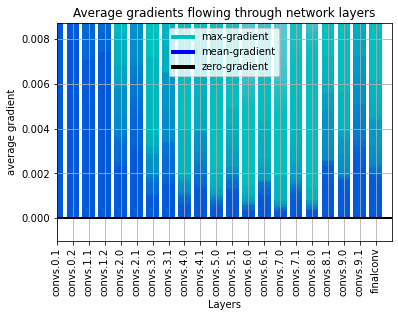

In [27]:
net, report = trainer.train_model(
    train_loader, val_loader,
    num_epochs=num_epochs,
    show_train_steps=None, show_validation_epochs=1,
    store_grads=show_grad_flow,
)

In [28]:
trainer.visualize_training(report, metrics=None, save_fig_path='./training_figures/fcn3d_cl_yaware_1_6trans_ver3')
# trainer.visualize_training(report, metrics=None, save_fig_path='')

# final reevaluation on the validation dataset
trainer.evaluate_model(val_loader)

here
loss
eval loss: 5.16101


In [29]:
np.array(report['train_metrics']['loss']).min()

5.284172482581468

In [30]:
np.array(report['train_metrics']['loss']).max()

5.632086171025513

In [31]:
torch.save(net.state_dict(), './fcn3d_cl_yaware_1_6trans_ver3.pth')